In [1]:
import random
import scipy
from scipy.io import arff
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
# import scikitplot as skplt
import sklearn
from sklearn import preprocessing
from sklearn import datasets 
from sklearn.impute import SimpleImputer


from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn import tree

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.transforms import *

In [2]:
#data sets
DATA_PATH = 'dataset/'
IMAGE_PATH = 'image/'
files = []
dfs = []
dfs_test = []

In [3]:
def plot_image(X):
    try:
        plt.imshow(np.array(X))
    except:
        plt.imshow(np.array(X).transpose(1,2,0))
    plt.show()
    
def dimension_reduction(x_train, x_test, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(x_train)
    x_train= pca.transform(x_train)
    x_test = pca.transform(x_test)
    return x_train, x_test

In [4]:
def load_CIFAR_10(training_batches=5, test_batches=1):
    X_train=y_train=X_test=y_test = None
    for b in range(1,training_batches+1):
        with open(DATA_PATH+'data_batch_%s'%b,'rb') as file:
            data = pickle.load(file,encoding='bytes')
            X = np.array(data[b'data'])
#             X = X.reshape(-1,3,32,32).transpose(0,2,3,1)
            y = np.array(data[b'labels'])
            try:
                X_train = np.concatenate((X_train,X))
                y_train = np.concatenate((y_train,y))
            except:
                print('first training batch')
                X_train = X
                y_train = y
                
    for b in range(1,test_batches+1):
        with open(DATA_PATH+'test_batch','rb') as file:
            data = pickle.load(file,encoding='bytes')
            X = np.array(data[b'data'])
#             X = X.reshape(-1,3,32,32).transpose(0,2,3,1)
            y = np.array(data[b'labels'])
            try:
                X_test = np.concatenate((X_test,X))
                y_test = np.concatenate((y_test,y))
            except:
                print('first test batch')
                X_test = X
                y_test = y
    return X_train,y_train,X_test,y_test

# Decision Tree

In [5]:
def train_DecisionTree(X_train, y_train):
    print('Training DecisionTree ...')
    tree = DecisionTreeClassifier(random_state=0)
    param_distributions = {
#         'max_depth' : scipy.stats.randint(100,200)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(tree,param_distributions,n_iter=1,cv=3,n_jobs=-1,
                                                        iid=False,random_state=0)
    randcv.fit(X_train, y_train)
    print('Training finished')
    return randcv

In [6]:
# X_train,y_train,X_test,y_test = load_CIFAR_10(1,1)
# X_train,X_test = dimension_reduction(X_train,X_test,100)
# %%time
# trees = train_DecisionTree(X_train,y_train)
# clf = trees.best_estimator_
# clf.score(X_test,y_test)

# CNN

In [7]:
def convert_to_images(X):
    return X.reshape(-1,3,32,32).transpose(0,2,3,1)

def transform_data(x_train,x_test):
    # tranform functions
    transform = Compose([
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#         Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
#         CenterCrop(32),
        ])
    
    x_train = convert_to_images(x_train)
    x_test = convert_to_images(x_test)
#     plot_image(x_train[0])
    #transformed dateset
    x_train = np.array([np.array(transform(x)) for x in x_train])
    x_test = np.array([np.array(transform(x)) for x in x_test])
#     plot_image(x_train[0])
    return x_train,x_test

In [8]:
X_train,y_train,X_test,y_test = load_CIFAR_10()

first training batch
first test batch


In [9]:
X_train,X_test = transform_data(X_train,X_test)
# X_train = X_train.reshape(-1,3,32,32)
# X_test = X_test.reshape(-1,3,32,32)

In [10]:
X_train = torch.tensor(X_train.astype(np.float32))
X_test = torch.tensor(X_test.astype(np.float32))
y_train = torch.tensor(y_train.astype(np.int64))
y_test = torch.tensor(y_test.astype(np.int64))

In [11]:
#cnn parameters
image_channels = X_train.shape[1]
image_width = X_train.shape[2]
num_filters = 32
num_filters2 = 64
num_filters3 = 128
filter_size = 5
pool_size = 2
# final_input = (((image_width+1-filter_size)//pool_size+1-filter_size)//pool_size)**2*num_filters2#without padding
final_input = (image_width//pool_size//pool_size//pool_size)**2*num_filters3#with padding

model = torch.nn.Sequential(
    torch.nn.Conv2d(image_channels, num_filters, filter_size, padding=filter_size//2),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(pool_size, pool_size),
    
    torch.nn.Conv2d(num_filters, num_filters2, filter_size, padding=filter_size//2),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(pool_size, pool_size),
    
    torch.nn.Conv2d(num_filters2, num_filters3, filter_size, padding=filter_size//2),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(pool_size, pool_size),
    
    torch.nn.Flatten(),
    torch.nn.Linear(final_input, final_input//2),
    torch.nn.ReLU(),
    
    torch.nn.Linear(final_input//2, final_input//4),
    torch.nn.ReLU(),
    
    torch.nn.Linear(final_input//4, final_input//16),
    torch.nn.ReLU(),

    torch.nn.Linear(final_input//16,10),
)

# model2 = torch.nn.Sequential(
#     torch.nn.Linear(final_input, final_input//2),
#     torch.nn.ReLU(),
    
#     torch.nn.Linear(final_input//2, final_input//4),
#     torch.nn.ReLU(),
    
#     torch.nn.Linear(final_input//4, final_input//16),
#     torch.nn.ReLU(),

#     torch.nn.Linear(final_input//16,10),
# )

In [12]:
def train_models(model,model2,X_train,X_test,y_train,y_test,final_input,batch_size,num_epoch):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-3)
#     optimizer2 = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-3)

    #mini-batch training loop
    for epoch in range(num_epoch):

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            X, y = data

            optimizer.zero_grad()
#             optimizer2.zero_grad()

            # forward + backward + optimize
#             X2 = model(X).view(-1,final_input)
#             y_pred = model2(X2)
            y_pred = model(X)

            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
#             optimizer2.step()

            #avg batch loss
            running_loss += loss.item()
            batch = 500
            if (i+1) % batch == 0:
                print('Epoch: %d, Batch: %5d had avg loss: %.3f'%(epoch+1,i+1,running_loss/batch))
                running_loss = 0.0
        if (epoch+1) % 5 ==0:
            torch.save(model.state_dict(), 'model_%s.pt'%epoch)
    torch.save(model.state_dict(), 'model.pt')
#     torch.save(model2.state_dict(), 'model2.pt')
    print('Training Finished')
#     return model,model2
    return model

In [13]:
# %%time
batch_size=16
num_epoch=28
# create torch Dataset class from tensors
train_set = torch.utils.data.TensorDataset(X_train, y_train)
test_set = torch.utils.data.TensorDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

try:
    model.load_state_dict(torch.load('model.pt'))
    print("Trained model loaded")
#     try:
#         model2.load_state_dict(torch.load('model2.pt'))
#     except:
#         pass
except:
    print('Model not found, start straining...')
#     model,model2 = train_models(model,model2,X_train,X_test,y_train,y_test,final_input,20,2)    
    model = train_models(model,None,X_train,X_test,y_train,y_test,final_input,batch_size,num_epoch)

Trained model loaded


In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        X, y = data
#         y_proba = model2(model(X).view(-1,final_input))
        y_proba = model(X)
        _, y_pred = torch.max(y_proba.data, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 78.68 %


In [15]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        X, y = data
#         y_proba = model2(model(X).view(-1,final_input))
        y_proba = model(X)
        _, y_pred = torch.max(y_proba, 1)
        c = (y_pred == y).squeeze()
        for i in range(4):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 83 %
Accuracy of   car : 89 %
Accuracy of  bird : 66 %
Accuracy of   cat : 63 %
Accuracy of  deer : 71 %
Accuracy of   dog : 70 %
Accuracy of  frog : 83 %
Accuracy of horse : 81 %
Accuracy of  ship : 87 %
Accuracy of truck : 88 %


# Activation maximization

In [ ]:
# loss = nn.CrossEntropyLoss()
# input = torch.randn(1, 5, requires_grad=True)
# target = torch.empty(1, dtype=torch.long).random_(5)
# print(target.data)
# for i in range(10):
#     output = loss(input, target)
#     output.backward()
#     input.data -= 0.2*input.grad.data 
#     print(input.data)

Target class: deer


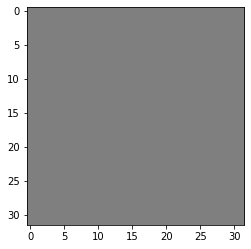

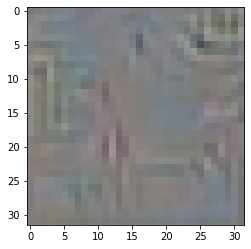

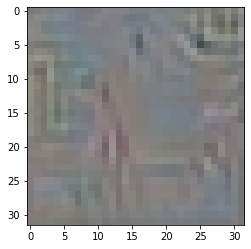

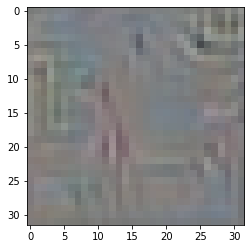

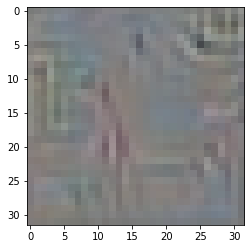

In [70]:
zeros = np.zeros((1,3,32,32)).astype(np.float32)
gray = zeros+0.5
X = torch.tensor(gray, requires_grad=True)
target = torch.empty(1, dtype=torch.long).random_(10)
print("Target class: %s"%classes[target])
# plot_image(gray)
criterion = nn.CrossEntropyLoss()

for i in range(1000):
    if i%200 ==0:
        plot_image(X[0].detach().numpy())    
        
    # y probabilities [p0,p1,...,p9]
    y_proba = model(X)
    
    #backward
    loss = criterion(y_proba, target)
    loss.backward()
    
    #minimize loss
    X.data -= 0.1*X.grad.data    



    X.grad.data.zero_()